In [1]:
import numpy as np
from pyIClab import (
    Eluent, SwitchingValve, SampleLoop, Dummy, Detector,
    PhreeqcSuppressor, IonChromatograph, DSM_CEConstrutor,
    DSM_SEConstrutor,
    )
from pyIClab.engines.equilibriums import find_x_LSSM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.integrate import quad

custom_rcconfig = {
    'figure.figsize': [8, 4],
    'figure.dpi': 300.0,
    'axes.linewidth': 1.0,
    'axes.labelsize': 14,
    'font.family': 'Arial',
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'mathtext.default': 'regular',
    'mathtext.fontset': 'dejavusans',
    'text.usetex': False,
    }
sns.set()
plt.rcParams.update(custom_rcconfig)


In [2]:
ic_collection = []
for constructor_type in [DSM_SEConstrutor, DSM_CEConstrutor]:
    eluent = Eluent.HydroxideIsocratic('20 mM', name='EG')
    valve = SwitchingValve.SixPort()
    loop = SampleLoop('Loop', V='25 uL')
    column = Dummy.Column()
    suppressor = PhreeqcSuppressor('Suppressor', kind='anion')
    detector = Detector('Detector', freq='10 Hz')

    valve.assemble(0, eluent)
    valve.assemble(1, column)
    valve.assemble([2, 5], loop)
    column.assemble(suppressor)
    suppressor.assemble(detector)

    ic = IonChromatograph('IC', competing_ions=('OH-',), lockon=valve)
    ic_collection.append(ic)
    
    sample = {'Cl[-1]': '0.1 mM'}
    commands = '''
        0 min, sixport, inject
        0.5 min, sixport, load
        '''

    ic.inject(sample, 'loop')
    ic.reset_commands(commands)
    ic.set_ModelConstructor(constructor_type, 'dummy')
    ic.go(tmax='5 min')


11:35:20 Activating <IC System "IC">...
    11:35:20 Configurating model paratemers...
    11:35:21 Building models...
    11:35:21 Injecting Samples...
        0.0 min: Execute Command -- <Valve "SixPort"> INJECT


Processing Cl[-1] on <Loop "Loop" 25 μL>:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing Cl[-1] on <Column "Dummy" (4.6 × 150 mm)>:   0%|          | 0/1661 [00:00<?, ?it/s]

Suppressing eluent on <Suppressor "Suppressor">...:   0%|          | 0/2000 [00:00<?, ?it/s]

        0.5 min: Execute Command -- <Valve "SixPort"> LOAD


Processing Cl[-1] on <Column "Dummy" (4.6 × 150 mm)>:   0%|          | 0/14944 [00:00<?, ?it/s]

Suppressing eluent on <Suppressor "Suppressor">...:   0%|          | 0/18000 [00:00<?, ?it/s]

11:35:26 IC simulation finished...

11:35:26 Activating <IC System "IC">...
    11:35:26 Configurating model paratemers...
    11:35:27 Building models...
    11:35:27 Injecting Samples...
        0.0 min: Execute Command -- <Valve "SixPort"> INJECT


Processing Cl[-1] on <Loop "Loop" 25 μL>:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing Cl[-1] on <Column "Dummy" (4.6 × 150 mm)>:   0%|          | 0/1661 [00:00<?, ?it/s]

Suppressing eluent on <Suppressor "Suppressor">...:   0%|          | 0/2000 [00:00<?, ?it/s]

        0.5 min: Execute Command -- <Valve "SixPort"> LOAD


Processing Cl[-1] on <Column "Dummy" (4.6 × 150 mm)>:   0%|          | 0/14944 [00:00<?, ?it/s]

Suppressing eluent on <Suppressor "Suppressor">...:   0%|          | 0/18000 [00:00<?, ?it/s]

11:35:33 IC simulation finished...



Text(0.5, 0.98, '25 μL Injection of 0.1 mM Chloride')

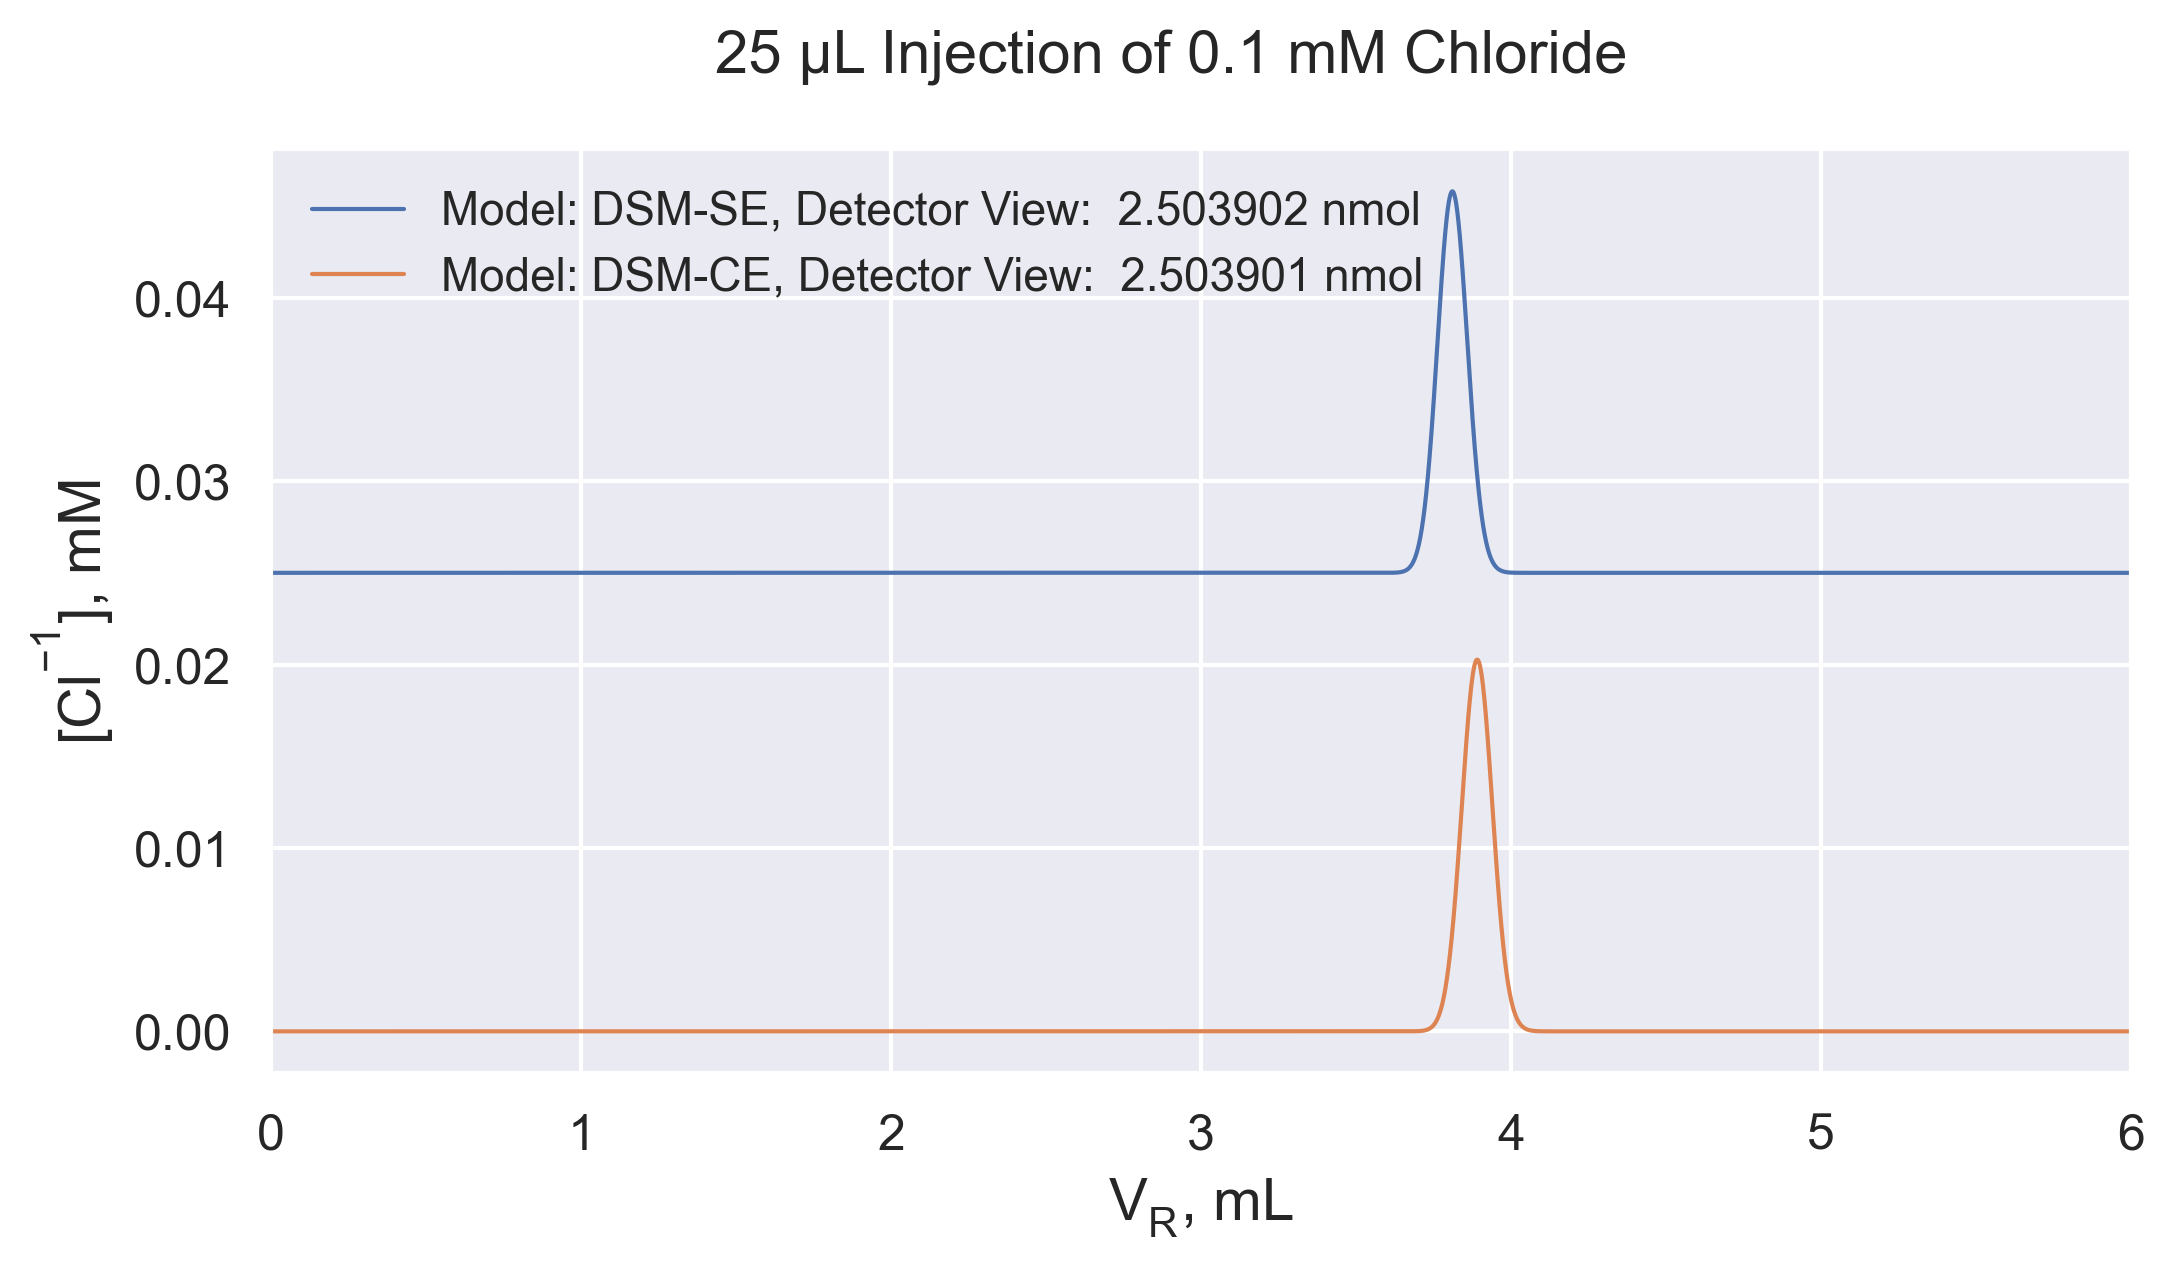

In [3]:
fig, ax = plt.subplots()
models = ['DSM-SE', 'DSM-CE']
for i, ic in enumerate(ic_collection):
    f = ic.detectors.pop().output['Cl[-1]']
    t = np.linspace(0, 6, 100000)
    c = f(t)
    ax.plot(t, c - (i-1)*0.025,
        label=f'Model: {models[i]}, Detector View: {quad(f, 3, 5)[0]*1e3: 7f} nmol'
        )

ax.set(xlim=(0, 6))
ax.set_xlabel(r'$V_{R}$, mL') # Fr = 1 mL/min
ax.set_ylabel(r'$[Cl^{-1}]$, mM')
ax.legend()
fig.suptitle('25 μL Injection of 0.1 mM Chloride')